<a href="https://colab.research.google.com/github/GuohaoZ/Quora-Insincere-Question/blob/master/quora_demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle #安装kaggle命令行工具
!mkdir -p ~/.kaggle # 用用户名和apikey 登陆
!echo '{"username":"yizhengf","key":"719be4825d9b94e59ca01cf12d41434e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!mkdir -p raw 
!kaggle competitions download -c quora-insincere-questions-classification -p raw

100% 5.96G/5.96G [03:25<00:00, 8.18MB/s]

  0% 0.00/649k [00:00<?, ?B/s]
100% 649k/649k [00:00<00:00, 93.3MB/s]
  0% 0.00/2.36M [00:00<?, ?B/s]
100% 2.36M/2.36M [00:00<00:00, 206MB/s]
 99% 54.0M/54.4M [00:01<00:00, 23.5MB/s]
100% 54.4M/54.4M [00:01<00:00, 33.2MB/s]


In [0]:
import zipfile
with zipfile.ZipFile('raw/train.csv.zip',"r") as zip_ref:
    zip_ref.extractall("data")

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
!cd raw

In [8]:
train_df = pd.read_csv('data//train.csv')
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
import zipfile
with zipfile.ZipFile('raw/test.csv.zip',"r") as zip_ref:
    zip_ref.extractall("data")

In [10]:
test_df = pd.read_csv('data//test.csv')
test_df.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [11]:
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [0]:
counts=train_df['target'].value_counts()

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


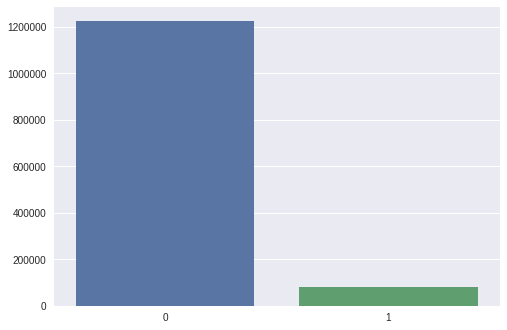

In [14]:
#counts summary
sns.barplot(y=counts.values, x = counts.index)


## **draw word cloud **

In [15]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 23.7MB/s 


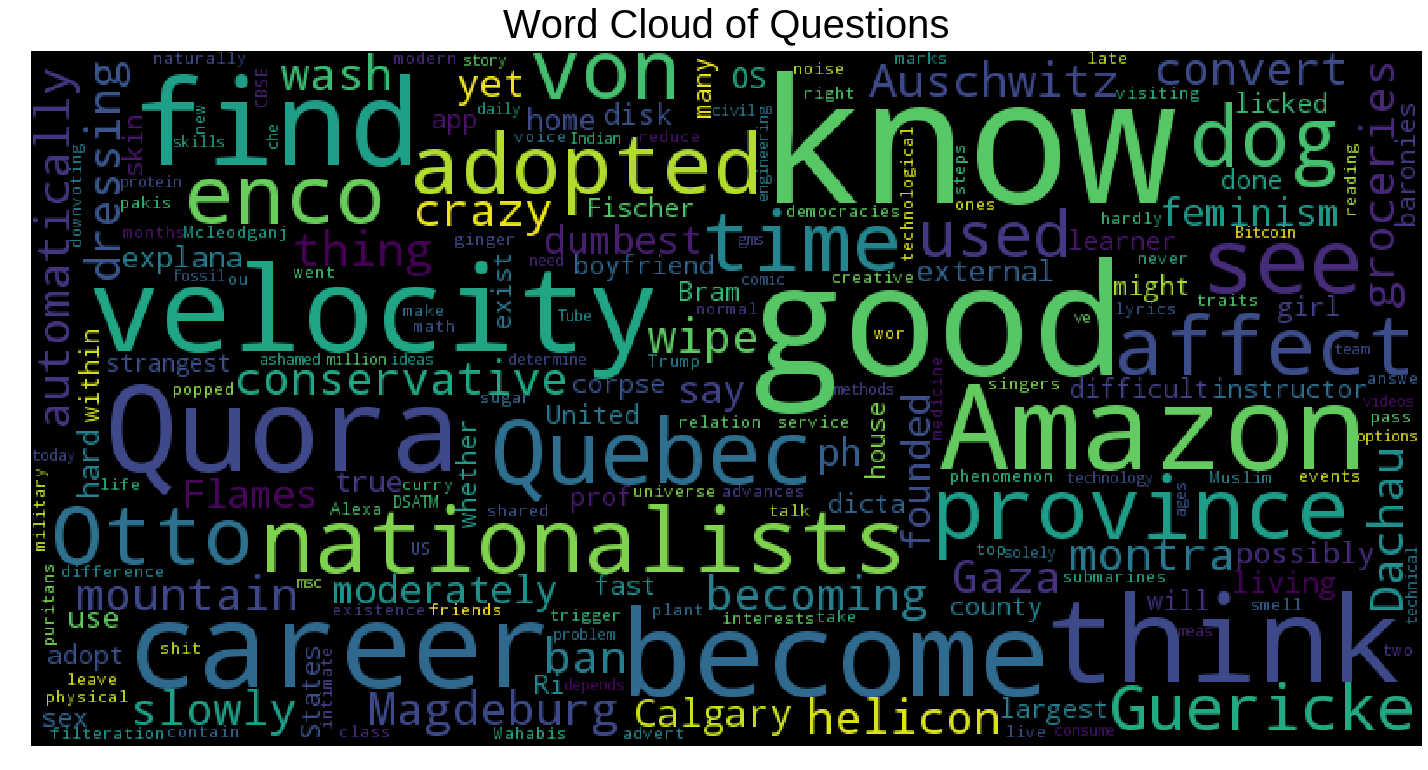

In [17]:
from wordcloud import WordCloud, STOPWORDS
## https://www.kaggle.com/aashita/word-clouds-of-various-shapes  as reference for word cloud function ## 
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,12.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")


## **Data Process and load**

In [0]:
import pandas as pd
import numpy as np
import operator 
import re
from tqdm import tqdm
tqdm.pandas()

In [0]:
train = train_df.drop('target', axis=1)
test = test_df
df = pd.concat([train ,test])


In [24]:
print('Number of texts', df.shape[0])

Number of texts 1362492


## **Loading embeddings**

In [0]:
import zipfile
with zipfile.ZipFile('raw/embeddings.zip',"r") as zip_ref:
    zip_ref.extractall("data")

In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [26]:
sentences = train["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 1306122/1306122 [00:08<00:00, 156230.85it/s]


{'How': 261930, 'did': 33489, 'Quebec': 97, 'nationalists': 91, 'see': 9003}


In [27]:
!pip install --upgrade gensim

    100% |████████████████████████████████| 23.6MB 965kB/s 
    100% |████████████████████████████████| 1.4MB 12.6MB/s 
    100% |████████████████████████████████| 133kB 26.7MB/s 
    100% |████████████████████████████████| 61kB 20.2MB/s 
    100% |████████████████████████████████| 5.1MB 5.2MB/s 
    100% |████████████████████████████████| 552kB 15.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
from gensim.models import KeyedVectors

news_path = 'data/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=True)


In [0]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


In [30]:
oov = check_coverage(vocab,embeddings_index)
oov[:10]

100%|██████████| 508823/508823 [00:02<00:00, 193701.87it/s]


Found embeddings for 24.31% of vocab
Found embeddings for  78.75% of all text


[('to', 403183),
 ('a', 402682),
 ('of', 330825),
 ('and', 251973),
 ('India?', 16384),
 ('it?', 12900),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202)]

In [31]:
print('?' in embeddings_index)
print('&' in embeddings_index)

False
True


In [0]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [33]:
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_text(x))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)


100%|██████████| 1306122/1306122 [00:06<00:00, 191676.28it/s]


In [34]:
oov = check_coverage(vocab,embeddings_index)
oov[:10]

100%|██████████| 253623/253623 [00:01<00:00, 230432.28it/s]


Found embeddings for 57.38% of vocab
Found embeddings for  89.99% of all text


[('to', 406298),
 ('a', 403852),
 ('of', 332964),
 ('and', 254081),
 ('2017', 8781),
 ('2018', 7373),
 ('10', 6642),
 ('12', 3694),
 ('20', 2942),
 ('100', 2883)]

In [35]:
for i in range(10):
    print(embeddings_index.index2entity[i])

</s>
in
for
that
is
on
##
The
with
said


In [0]:
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [37]:
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_numbers(x))
sentences = train["question_text"].progress_apply(lambda x: x.split())
vocab = build_vocab(sentences)


100%|██████████| 1306122/1306122 [00:06<00:00, 187331.17it/s]


In [38]:
oov = check_coverage(vocab,embeddings_index)
oov[:20]

100%|██████████| 242997/242997 [00:01<00:00, 210746.35it/s]


Found embeddings for 60.41% of vocab
Found embeddings for  90.75% of all text


[('to', 406298),
 ('a', 403852),
 ('of', 332964),
 ('and', 254081),
 ('favourite', 1247),
 ('bitcoin', 987),
 ('colour', 976),
 ('doesnt', 918),
 ('centre', 886),
 ('Quorans', 858),
 ('cryptocurrency', 822),
 ('Snapchat', 807),
 ('travelling', 705),
 ('counselling', 634),
 ('btech', 632),
 ('didnt', 600),
 ('Brexit', 493),
 ('cryptocurrencies', 481),
 ('blockchain', 474),
 ('behaviour', 468)]

In [0]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'

                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [40]:
train["question_text"] = train["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
sentences = train["question_text"].progress_apply(lambda x: x.split())
to_remove = ['a','to','of','and']
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:06<00:00, 193626.01it/s]


In [41]:
oov = check_coverage(vocab,embeddings_index)
oov[:10]

100%|██████████| 242935/242935 [00:01<00:00, 223875.28it/s]


Found embeddings for 60.43% of vocab
Found embeddings for  98.96% of all text


[('bitcoin', 987),
 ('Quorans', 858),
 ('cryptocurrency', 822),
 ('Snapchat', 807),
 ('btech', 632),
 ('Brexit', 493),
 ('cryptocurrencies', 481),
 ('blockchain', 474),
 ('behaviour', 468),
 ('upvotes', 432)]

In [61]:
len(vocab)

242935

In [57]:
##############################################3
##下面的是直接利用keras 的模块 进行 embedding 好像更加简单， 上面是参考一个kernel 处理的embedding 
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
EMBEDDING_FILE = 'data/embeddings/glove.840B.300d/glove.840B.300d.txt'
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [0]:
X_train = train["question_text"].fillna("fillna").values
y_train = train["target"].values
X_test = test["question_text"].fillna("fillna").values


max_features = 40000
maxlen = 70
embed_size = 300

threshold = 0.35

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)